# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

1. Data is collected from May 2008 to November 2010 - for 43 marketing campaigns.
2. Data has 16 variables with labeled output result. Output result is whether the customer subscribed the term deposit or not.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import time

from sklearn                   import tree
from sklearn.dummy             import DummyClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.metrics           import precision_score, make_scorer, roc_auc_score
from sklearn.model_selection   import GridSearchCV, PredefinedSplit, train_test_split
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.svm               import SVC
from sklearn.tree              import DecisionTreeClassifier

In [2]:
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

encoder = ColumnTransformer(
    [('onehot', OneHotEncoder(), [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome'])])

In [6]:
# fit and transform the data
encoded_data = encoder.fit_transform(df)

# convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data)

# print the encoded DataFrame
print(encoded_df)


                                                       0
0        (0, 3)\t1.0\n  (0, 13)\t1.0\n  (0, 16)\t1.0\...
1        (0, 7)\t1.0\n  (0, 13)\t1.0\n  (0, 19)\t1.0\...
2        (0, 7)\t1.0\n  (0, 13)\t1.0\n  (0, 19)\t1.0\...
3        (0, 0)\t1.0\n  (0, 13)\t1.0\n  (0, 17)\t1.0\...
4        (0, 7)\t1.0\n  (0, 13)\t1.0\n  (0, 19)\t1.0\...
...                                                  ...
41183    (0, 5)\t1.0\n  (0, 13)\t1.0\n  (0, 21)\t1.0\...
41184    (0, 1)\t1.0\n  (0, 13)\t1.0\n  (0, 21)\t1.0\...
41185    (0, 5)\t1.0\n  (0, 13)\t1.0\n  (0, 22)\t1.0\...
41186    (0, 9)\t1.0\n  (0, 13)\t1.0\n  (0, 21)\t1.0\...
41187    (0, 5)\t1.0\n  (0, 13)\t1.0\n  (0, 21)\t1.0\...

[41188 rows x 1 columns]


In [7]:
encoded_df.corr(method='kendall')

""


<AxesSubplot:>

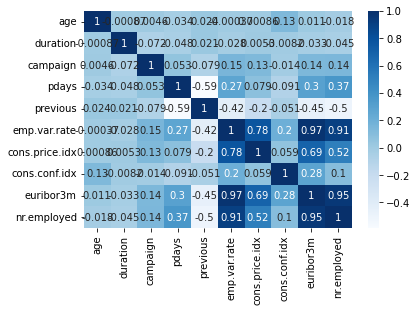

In [8]:
import seaborn as sb
corr = df.corr()
sb.heatmap(corr, cmap="Blues", annot=True)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [9]:
# Import necessary libraries
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from category_encoders import WOEEncoder
import category_encoders
import warnings
warnings.filterwarnings( 'ignore' )

# Create an instance of WOEEncoder
woe_encoder = WOEEncoder()

X = df[ ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan' ] ]
df['y'] = df['y'].map({'yes':1,'no':0})

X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1), df['y'], test_size=0.2, random_state=42)


# Fit and transform the categorical features with WOEEncoder
X_train_encoded = woe_encoder.fit_transform(X_train, y_train)
X_test_encoded = woe_encoder.fit_transform(X_test, y_test)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

###### The DummyClassifier is a classifier in scikit-learn that provides baseline performance by using simple rules for prediction. It can serve as a benchmark to compare the performance of other classifiers. 

In [10]:
output = pd.DataFrame( columns = [ 'Model',
                                    'Train Time',
                                    'Train Accuracy',
                                    'Test Accuracy'] )

In [11]:
# Create an instance of DummyClassifier using the desired strategy
model = DummyClassifier(strategy="stratified")

# Fit the model and find time to train using the training data
start = time.time()
model.fit(X_train_encoded, y_train)
stop  = time.time()
t_time = stop - start

# Calculate accuracy with train
y_train_pred = model.predict(X_train_encoded)
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy:", accuracy)

# Calculate accuracy with test
y_pred = model.predict(X_test_encoded)
test_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", test_accuracy)

# Create a new row as a dictionary
new_row = {'Model': 'DummyClassifier', 'Train Time': t_time, 'Train Accuracy' : accuracy, 'Test Accuracy' : test_accuracy}

# Using append() method
output = output.append(new_row, ignore_index=True)
print(output)

Accuracy: 0.7948103186646434
Accuracy: 0.8004369992716679
             Model Train Time Train Accuracy Test Accuracy
0  DummyClassifier   0.001332        0.79481      0.800437


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [12]:
# Create an instance of DummyClassifier using the desired strategy
model = LogisticRegression( class_weight = 'balanced', max_iter = 1000 )

# Fit the model and find time to train using the training data
start = time.time()
model.fit(X_train_encoded, y_train)
stop  = time.time()
t_time = stop - start



### Problem 9: Score the Model

What is the accuracy of your model?

In [13]:
# Calculate accuracy with train
y_train_pred = model.predict(X_train_encoded)
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy:", accuracy)

# Calculate accuracy with test
y_pred = model.predict(X_test_encoded)
test_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", test_accuracy)

# Create a new row as a dictionary
new_row = {'Model': 'LogisticRegression', 'Train Time': t_time, 'Train Accuracy' : accuracy, 'Test Accuracy' : test_accuracy}

# Using append() method
output = output.append(new_row, ignore_index=True)
print(output)

Accuracy: 0.8614871016691957
Accuracy: 0.8566399611556202
                Model Train Time Train Accuracy Test Accuracy
0     DummyClassifier   0.001332        0.79481      0.800437
1  LogisticRegression   0.806132       0.861487       0.85664


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [14]:
# Create an instance of DummyClassifier using the desired strategy
model = KNeighborsClassifier()

# Fit the model and find time to train using the training data
start = time.time()
model.fit(X_train_encoded, y_train)
stop  = time.time()
t_time = stop - start

# Calculate accuracy with train
y_train_pred = model.predict(X_train_encoded)
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy:", accuracy)

# Calculate accuracy with test
y_pred = model.predict(X_test_encoded)
test_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", test_accuracy)

# Create a new row as a dictionary
new_row = {'Model': 'KNeighborsClassifier', 'Train Time': t_time, 'Train Accuracy' : accuracy, 'Test Accuracy' : test_accuracy}

# Using append() method
output = output.append(new_row, ignore_index=True)
print(output)

Accuracy: 0.9316843702579666
Accuracy: 0.9014323865015781
                  Model Train Time Train Accuracy Test Accuracy
0       DummyClassifier   0.001332        0.79481      0.800437
1    LogisticRegression   0.806132       0.861487       0.85664
2  KNeighborsClassifier   0.013755       0.931684      0.901432


In [15]:
# Create an instance of DummyClassifier using the desired strategy
model = DecisionTreeClassifier()

# Fit the model and find time to train using the training data
start = time.time()
model.fit(X_train_encoded, y_train)
stop  = time.time()
t_time = stop - start

# Calculate accuracy with train
y_train_pred = model.predict(X_train_encoded)
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy:", accuracy)

# Calculate accuracy with test
y_pred = model.predict(X_test_encoded)
test_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", test_accuracy)

# Create a new row as a dictionary
new_row = {'Model': 'DecisionTreeClassifier', 'Train Time': t_time, 'Train Accuracy' : accuracy, 'Test Accuracy' : test_accuracy}

# Using append() method
output = output.append(new_row, ignore_index=True)
print(output)

Accuracy: 1.0
Accuracy: 0.8840738043214372
                    Model Train Time Train Accuracy Test Accuracy
0         DummyClassifier   0.001332        0.79481      0.800437
1      LogisticRegression   0.806132       0.861487       0.85664
2    KNeighborsClassifier   0.013755       0.931684      0.901432
3  DecisionTreeClassifier   0.117634            1.0      0.884074


In [16]:
model = SVC( class_weight = 'balanced', probability = True )

# Fit the model and find time to train using the training data
start = time.time()
model.fit(X_train_encoded, y_train)
stop  = time.time()
t_time = stop - start

# Calculate accuracy with train
y_train_pred = model.predict(X_train_encoded)
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy:", accuracy)

# Calculate accuracy with test
y_pred = model.predict(X_test_encoded)
test_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", test_accuracy)

# Create a new row as a dictionary
new_row = {'Model': 'SVC', 'Train Time': t_time, 'Train Accuracy' : accuracy, 'Test Accuracy' : test_accuracy}

# Using append() method
output = output.append(new_row, ignore_index=True)


Accuracy: 0.8411532625189682
Accuracy: 0.8428016508861375


In [17]:

print(output)

                    Model  Train Time Train Accuracy Test Accuracy
0         DummyClassifier    0.001332        0.79481      0.800437
1      LogisticRegression    0.806132       0.861487       0.85664
2    KNeighborsClassifier    0.013755       0.931684      0.901432
3  DecisionTreeClassifier    0.117634            1.0      0.884074
4                     SVC  205.136527       0.841153      0.842802


###### SVC has been slowest model of all. 
###### DecisionTreeClassifier seems to be overfitting for "Train Accuracy"
###### KNeighborsClassifier seems to give the best performance for both Train and Test data.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

###### High level approach would be to apply GridSearchCV for LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier and SVC
###### Reduce the data set from ~38k -> 1k to save GridSearchCV time

In [18]:
# Create an instance of Logistic Regression
logreg = LogisticRegression()

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)
grid_search.fit(X_train_encoded.head(1000), y_train.head(1000))

# Retrieve the best parameter values and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the model with the best parameters on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_encoded, y_test)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Test Accuracy:", test_accuracy)

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.9190000000000002
Test Accuracy: 0.9065307113377034


In [19]:
knn = KNeighborsClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train_encoded.head(1000), y_train.head(1000))

# Retrieve the best parameter values and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the model with the best parameters on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_encoded, y_test)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Test Accuracy:", test_accuracy)

Best Parameters: {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
Best Score: 0.915
Test Accuracy: 0.8996115562029618


In [20]:
dt = DecisionTreeClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5)
grid_search.fit(X_train_encoded.head(1000), y_train.head(1000))

# Retrieve the best parameter values and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the model with the best parameters on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_encoded, y_test)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Test Accuracy:", test_accuracy)

Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score: 0.915
Test Accuracy: 0.892571012381646


In [ ]:
# Create an instance of Support Vector Classifier
svc = SVC()

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
grid_search.fit(X_train_encoded.head(100), y_train.head(100))

# Retrieve the best parameter values and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the model with the best parameters on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_encoded, y_test)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Test Accuracy:", test_accuracy)